In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import proplot as pplot
import matplotlib.pyplot as plt
import cmaps
import cnmaps

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import transform
from cnmaps import get_map, draw_map, clip_contours_by_map
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

import rioxarray
import geopandas
from shapely.geometry import mapping
import scipy.stats
from scipy.stats import linregress

import os
os.chdir('/Users/zeqinhuang/Documents/paper/HW_track')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# data for drawing South China sea
with open('shapefiles/CN-border-L1.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]

river = shpreader.Reader('shapefiles/yangtze_yellow_river.shp')
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.3)
city_agg = shpreader.Reader('shapefiles/urban_agg_wgs84.shp')
city_feature = ShapelyFeature(city_agg.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.5)

# calculate summer time temperature anomomalies wrt climatologies of 1979-2010 (ERA5)
summer time is defined as JJA

In [3]:
reanalysis_dir = '/Volumes/Seagate_HZQ/reanalyses/'

t2m_summer_all = xr.open_dataarray('data/t2m_summer_1979_2022.nc')
t2m_summer_1979_2010 = t2m_summer_all.sel(time=slice(1979,2010))
t2m_summer_1979_2010_clim_mean = t2m_summer_1979_2010.mean(axis=2)
t2m_summer_ano = t2m_summer_all - t2m_summer_1979_2010_clim_mean
t2m_summer_ano_2022 = t2m_summer_ano[:,:,-1]

In [4]:
# calculate summer surface temperature larger than 1std or 2std
t2m_summer_1979_2010_clim_std = t2m_summer_1979_2010.std(axis=2)
t2m_summer_ano_2022_larger_1std = ((t2m_summer_ano_2022 > t2m_summer_1979_2010_clim_std)&(t2m_summer_ano_2022 < t2m_summer_1979_2010_clim_std *2)) |\
     ((t2m_summer_ano_2022 < -t2m_summer_1979_2010_clim_std)&(t2m_summer_ano_2022 > -t2m_summer_1979_2010_clim_std)*2)
t2m_summer_ano_2022_larger_2std = (t2m_summer_ano_2022 > t2m_summer_1979_2010_clim_std * 2) | (t2m_summer_ano_2022 < -t2m_summer_1979_2010_clim_std * 2)

# calculate heatwave days
heatwave days are defined as days when the daily temperature exceeds the 90% threshold of the calendar day based on a 5-day window during 1979-2010

In [5]:
for i in range(1979,2023):
    t2m_daily_i = xr.open_dataarray(reanalysis_dir + 'era5/' + '2m_temperature_daily_era5_' + str(i) + '.nc')
    t2m_daily_i = t2m_daily_i.sel(latitude = slice(54,17),longitude = slice(72,136))
    if i == 1979:
        t2m_daily_all = t2m_daily_i
    else:
        t2m_daily_i = t2m_daily_i
        t2m_daily_all = xr.concat([t2m_daily_all,t2m_daily_i], dim='time')

In [6]:
# calculate JJA daily heatwave threshold
# day-of-year of JJA ranges from 152-243
# note that groupby_bins are open in the left and close in the right
for i in range(152, 244):
    freeze_bins = [i-3,i+2]
    t2m_daily_all_1979_2010 = t2m_daily_all.sel(time=slice('1979-01-01','2010-12-31'))
    hw_threshold_i = t2m_daily_all_1979_2010.groupby_bins('time.dayofyear',freeze_bins).quantile(0.90, dim='time')
    if i == 152:
        hw_threshold_all = hw_threshold_i
    else:
        hw_threshold_all = xr.concat([hw_threshold_all, hw_threshold_i],dim='dayofyear_bins')

In [7]:
# calculate JJA daily SAT mean
# day-of-year of JJA ranges from 152-243
# note that groupby_bins are open in the left and close in the right
for i in range(152, 244):
    freeze_bins = [i-3,i+2]
    t2m_daily_all_1979_2010 = t2m_daily_all.sel(time=slice('1979-01-01','2010-12-31'))
    t2m_daily_mean_1979_2010_i = t2m_daily_all_1979_2010.groupby_bins('time.dayofyear',freeze_bins).mean(dim='time')
    if i == 152:
        t2m_daily_mean_1979_2010 = t2m_daily_mean_1979_2010_i
    else:
        t2m_daily_mean_1979_2010 = xr.concat([t2m_daily_mean_1979_2010, t2m_daily_mean_1979_2010_i],dim='dayofyear_bins')

In [8]:
# calculate heatwave days anomalies
JJA = t2m_daily_all.time.dt.month.isin(range(6,9))
t2m_daily_summer = t2m_daily_all.sel(time=JJA)

for i in range(1979,2023):
    t2m_daily_summer_i = t2m_daily_summer.sel(time=t2m_daily_summer.time.dt.year == i)
    hw_threshold_all_copy = hw_threshold_all.rename({'dayofyear_bins':'time'})
    hw_threshold_all_copy['time'] = t2m_daily_summer_i.time
    is_HWD_daily_i = t2m_daily_summer_i > hw_threshold_all_copy
    is_HWD_summer_i = is_HWD_daily_i.sum(dim='time',keepdims=True)
    is_HWD_summer_i = is_HWD_summer_i.assign_coords({'time':[i]})
    if i == 1979:
        is_HWD_summer_all = is_HWD_summer_i
    else:
        is_HWD_summer_all = xr.concat([is_HWD_summer_all,is_HWD_summer_i],dim='time')

is_HWD_summer_1979_2010 = is_HWD_summer_all.sel(time=slice(1979,2010))
is_HWD_summer_1979_2010_clim_mean = is_HWD_summer_1979_2010.mean(axis=0)
is_HWD_summer_ano = is_HWD_summer_all - is_HWD_summer_1979_2010_clim_mean
is_HWD_summer_ano_2022 = is_HWD_summer_ano[-1,:,:]

# is_HWD_summer_1979_2010.to_netcdf('data/hwd_summer_1979_2022.nc')

# calculate summer heatwave day anomalies larger than 1std or 2std
is_HWD_summer_1979_2010_clim_std = is_HWD_summer_1979_2010.std(axis=0)
is_HWD_summer_ano_2022_larger_1std = ((is_HWD_summer_ano_2022 > is_HWD_summer_1979_2010_clim_std)&(is_HWD_summer_ano_2022 < is_HWD_summer_1979_2010_clim_std *2)) |\
     ((is_HWD_summer_ano_2022 < -is_HWD_summer_1979_2010_clim_std)&(is_HWD_summer_ano_2022 > -is_HWD_summer_1979_2010_clim_std)*2)
is_HWD_summer_ano_2022_larger_2std = (is_HWD_summer_ano_2022 > is_HWD_summer_1979_2010_clim_std * 2) | (is_HWD_summer_ano_2022 < -is_HWD_summer_1979_2010_clim_std * 2)

In [9]:
# calculate HWL (length of the longest yearly heatwave event) anomalies
JJA = t2m_daily_all.time.dt.month.isin(range(6,9))
t2m_daily_summer = t2m_daily_all.sel(time=JJA)

def longestTrue(list1):
  list1 = list1 + [False]
  current_run = 0
  longest_run = 0
  for i in range(len(list1)):
    if list1[i]:
      current_run += 1
    else:
      if current_run > longest_run:
        longest_run = current_run
      current_run = 0
  return longest_run

for i in range(1979,2023):
    t2m_daily_summer_i = t2m_daily_summer.sel(time=t2m_daily_summer.time.dt.year == i)
    hw_threshold_all_copy = hw_threshold_all.rename({'dayofyear_bins':'time'})
    hw_threshold_all_copy['time'] = t2m_daily_summer_i.time
    is_HWD_daily_i = t2m_daily_summer_i > hw_threshold_all_copy
    HWL_summer_i = xr.apply_ufunc(longestTrue,is_HWD_daily_i,
                                    vectorize=True,
                                    dask='parallelized', 
                                    input_core_dims=[['time']],
                                    output_dtypes=[float],)
    HWL_summer_i = HWL_summer_i.expand_dims({'time':1}).assign_coords({'time':[i]})
    if i == 1979:
        HWL_summer_all = HWL_summer_i
    else:
        HWL_summer_all = xr.concat([HWL_summer_all,HWL_summer_i],dim='time')

HWL_summer_1979_2010 = HWL_summer_all.sel(time=slice(1979,2010))
HWL_summer_1979_2010_clim_mean = HWL_summer_1979_2010.mean(axis=0)
HWL_summer_ano = HWL_summer_all - HWL_summer_1979_2010_clim_mean
HWL_summer_ano_2022 = HWL_summer_ano[-1,:,:]

HWL_summer_all.to_netcdf('data/hwl_summer_1979_2022.nc')

# calculate summer HWL anomalies larger than 1std or 2std
HWL_summer_1979_2010_clim_std = HWL_summer_1979_2010.std(axis=0)
HWL_summer_ano_2022_larger_1std = ((HWL_summer_ano_2022 > HWL_summer_1979_2010_clim_std)&(HWL_summer_ano_2022 < HWL_summer_1979_2010_clim_std *2)) |\
     ((HWL_summer_ano_2022 < -HWL_summer_1979_2010_clim_std)&(HWL_summer_ano_2022 > -HWL_summer_1979_2010_clim_std)*2)
HWL_summer_ano_2022_larger_2std = (HWL_summer_ano_2022 > HWL_summer_1979_2010_clim_std * 2) | (HWL_summer_ano_2022 < -HWL_summer_1979_2010_clim_std * 2)

In [10]:
# calculate HWM (Average magnitude of all yearly events) anomalies
JJA = t2m_daily_all.time.dt.month.isin(range(6,9))
t2m_daily_summer = t2m_daily_all.sel(time=JJA)

def longestTrue(list1):
  list1 = list1 + [False]
  current_run = 0
  longest_run = 0
  for i in range(len(list1)):
    if list1[i]:
      current_run += 1
    else:
      if current_run > longest_run:
        longest_run = current_run
      current_run = 0
  return longest_run

for i in range(1979,2023):
    t2m_daily_summer_i = t2m_daily_summer.sel(time=t2m_daily_summer.time.dt.year == i)
    hw_threshold_all_copy = hw_threshold_all.rename({'dayofyear_bins':'time'})
    hw_threshold_all_copy['time'] = t2m_daily_summer_i.time
    is_HWD_daily_i = t2m_daily_summer_i > hw_threshold_all_copy
    HWM_daily_i = (t2m_daily_summer_i - hw_threshold_all_copy) * is_HWD_daily_i
    is_HWD_summer_i = is_HWD_daily_i.sum(dim='time',keepdims=True)
    HWM_summer_i = HWM_daily_i.sum(dim='time') / is_HWD_summer_i
    HWM_summer_i = HWM_summer_i.assign_coords({'time':[i]})
    if i == 1979:
        HWM_summer_all = HWM_summer_i
    else:
        HWM_summer_all = xr.concat([HWM_summer_all,HWM_summer_i],dim='time')

HWM_summer_1979_2010 = HWM_summer_all.sel(time=slice(1979,2010))
HWM_summer_1979_2010_clim_mean = HWM_summer_1979_2010.mean(dim='time')
HWM_summer_ano = HWM_summer_all - HWM_summer_1979_2010_clim_mean
HWM_summer_ano_2022 = HWM_summer_ano[:,:,-1]

HWM_summer_all.to_netcdf('data/hwm_summer_1979_2022.nc')

# calculate summer HWM anomalies larger than 1std or 2std
HWM_summer_1979_2010_clim_std = HWM_summer_1979_2010.std(dim='time')
HWM_summer_ano_2022_larger_1std = ((HWM_summer_ano_2022 > HWM_summer_1979_2010_clim_std)&(HWM_summer_ano_2022 < HWM_summer_1979_2010_clim_std *2)) |\
     ((HWM_summer_ano_2022 < -HWM_summer_1979_2010_clim_std)&(HWM_summer_ano_2022 > -HWM_summer_1979_2010_clim_std)*2)
HWM_summer_ano_2022_larger_2std = (HWM_summer_ano_2022 > HWM_summer_1979_2010_clim_std * 2) | (HWM_summer_ano_2022 < -HWM_summer_1979_2010_clim_std * 2)

# calculate YRB annual SAT, HWD anomalies

In [58]:
# calculate the standardized time series of SAT averaged over the YRB during 1979-2022 (wrt 1979-2010 mean and std)
t2m_summer_ano_YRB = t2m_summer_ano.sel(latitude = slice(35,25),longitude = slice(100,122.5))
weights = np.cos(np.deg2rad(t2m_summer_ano_YRB.latitude))
weights.name = 'weights'
t2m_summer_ano_YRB_weighted = t2m_summer_ano_YRB.weighted(weights)
t2m_summer_ano_YRB_ts = t2m_summer_ano_YRB_weighted.mean(('longitude','latitude'))
print('The summer surface temperature anomalies over the YRB in 2022 is :' + str(t2m_summer_ano_YRB_ts[-1].values))
t2m_summer_ano_YRB_ts_std = (t2m_summer_ano_YRB_ts - t2m_summer_ano_YRB_ts[:32].mean()) / t2m_summer_ano_YRB_ts[:32].std()
print('The summer surface temperature stadard deviation over the YRB in 2022 is :' + str(t2m_summer_ano_YRB_ts_std[-1].values))

The summer surface temperature anomalies over the YRB in 2022 is :1.7902901
The summer surface temperature stadard deviation over the YRB in 2022 is :4.591279478353847


In [59]:
# calculate the standardized time series of HWD averaged over the YRB during 1979-2022 (wrt 1979-2010 mean and std)
is_HWD_summer_ano_YRB = is_HWD_summer_ano.sel(latitude = slice(35,25),longitude = slice(100,122.5))
weights = np.cos(np.deg2rad(is_HWD_summer_ano_YRB.latitude))
weights.name = 'weights'
is_HWD_summer_ano_YRB_weighted = is_HWD_summer_ano_YRB.weighted(weights)
is_HWD_summer_ano_YRB_ts = is_HWD_summer_ano_YRB_weighted.mean(('longitude','latitude'))
print('The summer heatwave day averaged over the YRB in 2022 is :' + str(is_HWD_summer_ano_YRB_ts[-1].values))
is_HWD_summer_ano_YRB_ts_std = (is_HWD_summer_ano_YRB_ts - is_HWD_summer_ano_YRB_ts[:32].mean()) / is_HWD_summer_ano_YRB_ts[:32].std()
print('The summer surface temperature stadard deviation averaged over the YRB in 2022 is :' + str(is_HWD_summer_ano_YRB_ts_std[-1].values))

The summer heatwave day averaged over the YRB in 2022 is :28.206958552775152
The summer surface temperature stadard deviation averaged over the YRB in 2022 is :6.924182385462788


In [60]:
np.corrcoef([t2m_summer_ano_YRB_ts_std,is_HWD_summer_ano_YRB_ts_std])

array([[1.        , 0.91176773],
       [0.91176773, 1.        ]])

In [62]:
# calculate the time series of SAT averaged over the YRB during 1979-2022
t2m_summer_all_YRB = t2m_summer_all.sel(latitude = slice(35,25),longitude = slice(100,122.5))
weights = np.cos(np.deg2rad(t2m_summer_all_YRB.latitude))
weights.name = 'weights'
t2m_summer_all_YRB_weighted = t2m_summer_all_YRB.weighted(weights)
t2m_summer_all_YRB_ts = t2m_summer_all_YRB_weighted.mean(('longitude','latitude'))
print('The summer surface temperature over the YRB in 2022 is :' + str(t2m_summer_all_YRB_ts[-1].values))

t2m_summer_all_YRB_ts = t2m_summer_all_YRB_ts.to_dataframe()['t2m']
# t2m_summer_all_YRB_ts.to_csv('data/YRB_averaged_SAT_1979_2022.csv')

The summer surface temperature over the YRB in 2022 is :298.13608


In [63]:
# calculate the time series of HWD averaged over the YRB during 1979-2022
is_HWD_summer_all_YRB = is_HWD_summer_all.sel(latitude = slice(35,25),longitude = slice(100,122.5))
weights = np.cos(np.deg2rad(is_HWD_summer_all_YRB.latitude))
weights.name = 'weights'
is_HWD_summer_all_YRB_weighted = is_HWD_summer_all_YRB.weighted(weights)
is_HWD_summer_all_YRB_ts = is_HWD_summer_all_YRB_weighted.mean(('longitude','latitude'))
print('The averaged HWD over the YRB in 2022 is :' + str(is_HWD_summer_all_YRB_ts[-1].values))

is_HWD_summer_all_YRB_ts = is_HWD_summer_all_YRB_ts.to_dataframe()['t2m']
is_HWD_summer_all_YRB_ts.to_csv('data/YRB_averaged_HWD_1979_2022.csv')

The averaged HWD over the YRB in 2022 is :37.38320771015555


# calculate YRB annual HWL, HWM anomalies

In [64]:
# calculate the standardized time series of HWL averaged over the YRB during 1979-2022 (wrt 1979-2010 mean and std)
HWL_summer_ano_YRB = HWL_summer_ano.sel(latitude = slice(35,25),longitude = slice(100,122.5))
weights = np.cos(np.deg2rad(HWL_summer_ano_YRB.latitude))
weights.name = 'weights'
HWL_summer_ano_YRB_weighted = HWL_summer_ano_YRB.weighted(weights)
HWL_summer_ano_YRB_ts = HWL_summer_ano_YRB_weighted.mean(('longitude','latitude'))
print('The summer heatwave day averaged over the YRB in 2022 is :' + str(HWL_summer_ano_YRB_ts[-1].values))
HWL_summer_ano_YRB_ts_std = (HWL_summer_ano_YRB_ts - HWL_summer_ano_YRB_ts[:32].mean()) / HWL_summer_ano_YRB_ts[:32].std()
print('The summer surface temperature stadard deviation averaged over the YRB in 2022 is :' + str(HWL_summer_ano_YRB_ts_std[-1].values))

The summer heatwave day averaged over the YRB in 2022 is :11.45900374223469
The summer surface temperature stadard deviation averaged over the YRB in 2022 is :9.882301314147327


In [65]:
# calculate the standardized time series of HWM averaged over the YRB during 1979-2022 (wrt 1979-2010 mean and std)
HWM_summer_ano_YRB = HWM_summer_ano.sel(latitude = slice(35,25),longitude = slice(100,122.5))
weights = np.cos(np.deg2rad(HWM_summer_ano_YRB.latitude))
weights.name = 'weights'
HWM_summer_ano_YRB_weighted = HWM_summer_ano_YRB.weighted(weights)
HWM_summer_ano_YRB_ts = HWM_summer_ano_YRB_weighted.mean(('longitude','latitude'))
print('The summer heatwave day averaged over the YRB in 2022 is :' + str(HWM_summer_ano_YRB_ts[-1].values))
HWM_summer_ano_YRB_ts_std = (HWM_summer_ano_YRB_ts - HWM_summer_ano_YRB_ts[:32].mean()) / HWM_summer_ano_YRB_ts[:32].std()
print('The summer surface temperature stadard deviation averaged over the YRB in 2022 is :' + str(HWM_summer_ano_YRB_ts_std[-1].values))

The summer heatwave day averaged over the YRB in 2022 is :0.8148063041062793
The summer surface temperature stadard deviation averaged over the YRB in 2022 is :6.951616409203375


In [66]:
np.corrcoef([HWL_summer_ano_YRB_ts_std,HWM_summer_ano_YRB_ts_std])

array([[1.        , 0.88502117],
       [0.88502117, 1.        ]])

In [67]:
# calculate the time series of HWD averaged over the YRB during 1979-2022
HWL_summer_all_YRB = HWL_summer_all.sel(latitude = slice(35,25),longitude = slice(100,122.5))
weights = np.cos(np.deg2rad(HWL_summer_all_YRB.latitude))
weights.name = 'weights'
HWL_summer_all_YRB_weighted = HWL_summer_all_YRB.weighted(weights)
HWL_summer_all_YRB_ts = HWL_summer_all_YRB_weighted.mean(('longitude','latitude'))
print('The averaged HWD over the YRB in 2022 is :' + str(HWL_summer_all_YRB_ts[-1].values))

HWL_summer_all_YRB_ts = HWL_summer_all_YRB_ts.to_dataframe()['t2m']
HWL_summer_all_YRB_ts.to_csv('data/YRB_averaged_HWL_1979_2022.csv')

The averaged HWD over the YRB in 2022 is :14.961546564565582


In [68]:
# calculate the time series of HWD averaged over the YRB during 1979-2022
HWM_summer_all_YRB = HWM_summer_all.sel(latitude = slice(35,25),longitude = slice(100,122.5))
weights = np.cos(np.deg2rad(HWM_summer_all_YRB.latitude))
weights.name = 'weights'
HWM_summer_all_YRB_weighted = HWM_summer_all_YRB.weighted(weights)
HWM_summer_all_YRB_ts = HWM_summer_all_YRB_weighted.mean(('longitude','latitude'))
print('The averaged HWD over the YRB in 2022 is :' + str(HWM_summer_all_YRB_ts[-1].values))

HWM_summer_all_YRB_ts = HWM_summer_all_YRB_ts.to_dataframe()['t2m']
HWM_summer_all_YRB_ts.to_csv('data/YRB_averaged_HWM_1979_2022.csv')

The averaged HWD over the YRB in 2022 is :1.4753504192209417


# plot figure S2

In [76]:
from descartes import PolygonPatch
import shapefile
import matplotlib.path as mpath
import matplotlib.patches as mpatches
source_path = 'shapefiles/country.shp'

Path = mpath.Path
sfile = shapefile.Reader(source_path)
for shape_rec in sfile.shapeRecords():
    vertices = []
    codes = []
    pts = shape_rec.shape.points
    prt = list(shape_rec.shape.parts) + [len(pts)]
    for i in range(len(prt) - 1):
        for j in range(prt[i], prt[i+1]):
            vertices.append((pts[j][0], pts[j][1]))
        codes += [Path.MOVETO]
        codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
        codes += [Path.CLOSEPOLY]
    clip = mpath.Path(vertices, codes)
    clip = mpatches.PathPatch(clip,visible=False,transform=ccrs.PlateCarree())

In [88]:
reg_func = np.poly1d(np.polyfit(t2m_summer_ano_YRB_ts_std.time, t2m_summer_ano_YRB_ts_std, 1))
print('historical SAT in YRB has increased by {:.4f} (1std)'.format(reg_func[1]))
SAT_trend = reg_func[1] * t2m_summer_ano_YRB_ts[:32].std()
print('Equivalent to {:.4f} (°C/year)'.format(SAT_trend.values))

historical SAT in YRB has increased by 0.0698 (1std)
Equivalent to 0.0272 (°C/year)


In [89]:
reg_func = np.poly1d(np.polyfit(is_HWD_summer_ano_YRB_ts_std.time, is_HWD_summer_ano_YRB_ts_std, 1))
print('historical HWD in YRB has increased by {:.4f} (1std)'.format(reg_func[1]))
HWD_trend = reg_func[1] * is_HWD_summer_ano_YRB_ts[:32].std()
print('Equivalent to {:.4f} (days/year)'.format(HWD_trend.values))

historical HWD in YRB has increased by 0.0903 (1std)
Equivalent to 0.3678 (days/year)


In [90]:
reg_func = np.poly1d(np.polyfit(HWL_summer_ano_YRB_ts_std.time, HWL_summer_ano_YRB_ts_std, 1))
print('historical HWL in YRB has increased by {:.4f} (1std)'.format(reg_func[1]))
HWL_trend = reg_func[1] * HWL_summer_ano_YRB_ts[:32].std()
print('Equivalent to {:.4f} (days/year)'.format(HWL_trend.values))

historical HWL in YRB has increased by 0.1031 (1std)
Equivalent to 0.1196 (days/year)


In [92]:
reg_func = np.poly1d(np.polyfit(HWM_summer_ano_YRB_ts_std.time, HWM_summer_ano_YRB_ts_std, 1))
print('historical HWM in YRB has increased by {:.4f} (1std)'.format(reg_func[1]))
HWM_trend = reg_func[1] * HWM_summer_ano_YRB_ts[:32].std()
print('Equivalent to {:.4f} (°C/year)'.format(HWM_trend.values))

historical HWM in YRB has increased by 0.0714 (1std)
Equivalent to 0.0084 (°C/year)


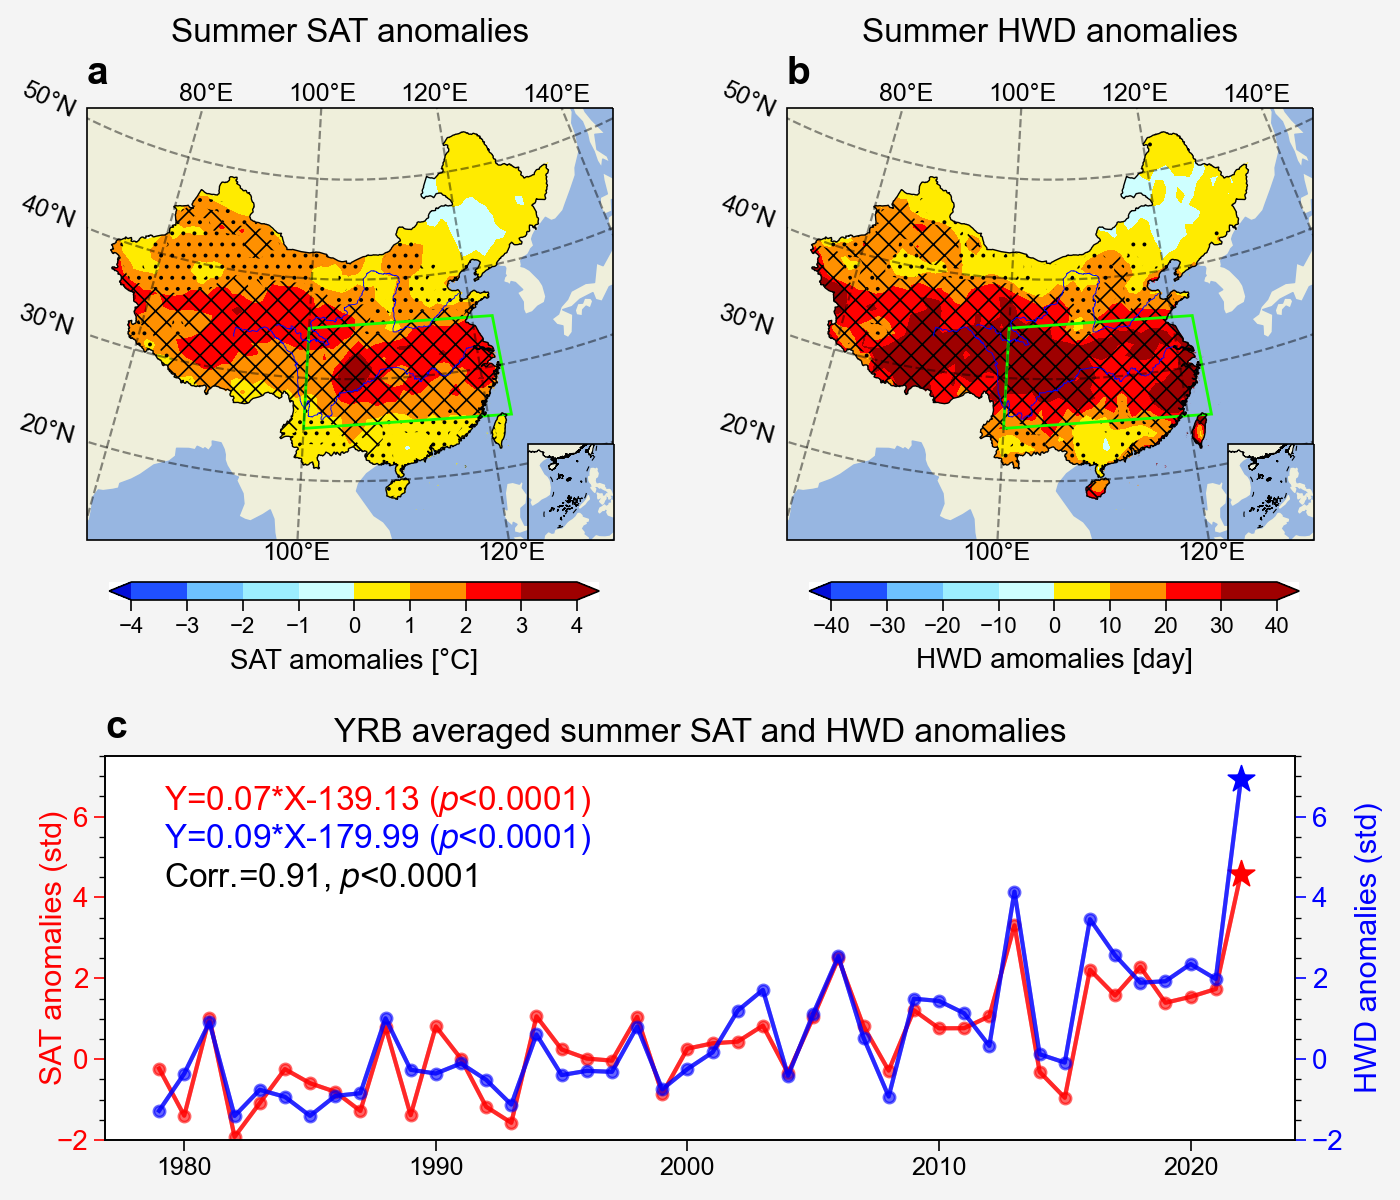

In [110]:
from matplotlib.patches import Rectangle
import matplotlib as mpl
from copy import copy

axes_locs = [
    [0.05,0.55,0.4,0.36],
    [0.55,0.55,0.4,0.36],
    [0.075,0.05,0.85,0.32]
]

sub_axes_locs = [
    [0.368, 0.55, 0.08, 0.08],
    [0.868, 0.55, 0.08, 0.08],
]

cbar_locs = [
    [0.078, 0.5, 0.35, 0.015],
    [0.578, 0.5, 0.35, 0.015],
]

fig = plt.figure(figsize = (7,6))

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top', ha='left')

# ax1 for SAT anomalies
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
ax1 = fig.add_axes(axes_locs[0], projection = mapcrs)
ax1.add_feature(cfeature.LAND.with_scale('110m'))
ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
ax1.add_feature(river_feature)
ax1.set_extent([80, 130, 13, 55])
ax1.set_title('Summer SAT anomalies',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)
china = get_map('中国')
draw_map(china,color='black',linewidth=0.5)
sub_ax = fig.add_axes(sub_axes_locs[0], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))#
sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', color='black',transform=ccrs.Geodetic(),linewidth=0.4)
sub_ax.set_extent([105, 125, 0, 25])

lon = t2m_summer_ano_2022['longitude']
lat = t2m_summer_ano_2022['latitude']
clip_copy = copy(clip)
ax1.add_patch(clip_copy)
p2 = ax1.contourf(lon, lat, t2m_summer_ano_2022, cmap=cmaps.GMT_panoply, levels=[-4,-3,-2,-1,0,1,2,3,4],extend = 'both', transform=ccrs.PlateCarree()) #vmin=-4, vmax=4,
# mpl.rc('hatch', color='k', linewidth=2.5)
p3 = ax1.contourf(
    lon, lat, t2m_summer_ano_2022_larger_1std,
    transform=ccrs.PlateCarree(),
    colors='none',
    edgecolor='gray',
    levels=[.5, 1.5],
    hatches=['...',None],
    linewidth=2
)
p4 = ax1.contourf(
    lon, lat, t2m_summer_ano_2022_larger_2std,
    transform=ccrs.PlateCarree(),
    colors='none',
    edgecolor='gray',
    levels=[.5, 1.5],
    hatches=['xxx',None],
    linewidth=1
)
ax1.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,transform=ccrs.PlateCarree()))
for c in p2.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)
for c in p3.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)
for c in p4.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

cbar_ax = fig.add_axes(cbar_locs[0])
fig_cbar = fig.colorbar(p2, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('SAT amomalies [°C]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl2 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
gl2.xlabel_style = {'rotation': 0, 'ha':'center'}
gl2.right_labels = False

# ax2 for HWD anomalies
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
ax2 = fig.add_axes(axes_locs[1], projection = mapcrs)
ax2.add_feature(cfeature.LAND.with_scale('110m'))
ax2.add_feature(cfeature.OCEAN.with_scale('110m'))
ax2.add_feature(river_feature)
ax2.set_extent([80, 130, 13, 55])
ax2.set_title('Summer HWD anomalies',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)
china = get_map('中国')
draw_map(china,color='black',linewidth=0.5)
sub_ax = fig.add_axes(sub_axes_locs[1], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))#
sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', color='black',transform=ccrs.Geodetic(),linewidth=0.4)
sub_ax.set_extent([105, 125, 0, 25])

lon = is_HWD_summer_ano_2022['longitude']
lat = is_HWD_summer_ano_2022['latitude']
clip_copy = copy(clip)
ax2.add_patch(clip_copy)
p2 = ax2.contourf(lon, lat, is_HWD_summer_ano_2022, cmap=cmaps.GMT_panoply, levels=[-40,-30,-20,-10,0,10,20,30,40],extend = 'both', transform=ccrs.PlateCarree()) #vmin=-4, vmax=4,
# mpl.rc('hatch', color='k', linewidth=2.5)
p3 = ax2.contourf(
    lon, lat, is_HWD_summer_ano_2022_larger_1std,
    transform=ccrs.PlateCarree(),
    colors='none',
    edgecolor='gray',
    levels=[.5, 1.5],
    hatches=['...',None],
    linewidth=2
)
p4 = ax2.contourf(
    lon, lat, is_HWD_summer_ano_2022_larger_2std,
    transform=ccrs.PlateCarree(),
    colors='none',
    edgecolor='gray',
    levels=[.5, 1.5],
    hatches=['xxx',None],
    linewidth=1
)
ax2.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,transform=ccrs.PlateCarree()))
for c in p2.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)
for c in p3.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)
for c in p4.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

cbar_ax = fig.add_axes(cbar_locs[1])
fig_cbar = fig.colorbar(p2, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('HWD amomalies [day]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
gl2.xlabel_style = {'rotation': 0, 'ha':'center'}
gl2.right_labels = False

# ax3 for YRB SAT and HWD std time series
ax3 = fig.add_axes(axes_locs[2])

ax3.plot(np.arange(1979,2023),t2m_summer_ano_YRB_ts_std,color = 'r',markersize=4,marker = 'o',alpha=0.6)
ax3.plot(np.arange(1979,2023),t2m_summer_ano_YRB_ts_std,'-',color = 'r',linewidth=1.5,alpha=0.6)
ax3.scatter(x = [2022],y = t2m_summer_ano_YRB_ts_std[-1], marker='*', color = 'r',s=100,alpha=1)
ax3.set_ylim(-2,7.5)
ax3.tick_params(axis='y',colors='red',labelsize = 10)
ax3.set_ylabel('SAT anomalies (std)',fontdict={'fontsize':11},labelpad=-4)
ax3.xaxis.set_tick_params(which='minor', bottom=False)
ax3.yaxis.label.set_color('r')
ax3.grid(False)
ax3.set_title('YRB averaged summer SAT and HWD anomalies',fontdict={'fontsize':12,'fontweight': 'medium'},y=1)

ax3_twin = ax3.twinx()
ax3_twin.plot(np.arange(1979,2023),is_HWD_summer_ano_YRB_ts_std,color = 'b',markersize=4,marker = 'o',alpha=0.6)
ax3_twin.plot(np.arange(1979,2023),is_HWD_summer_ano_YRB_ts_std,'-',color = 'b',linewidth=1.5,alpha=0.6)
ax3_twin.scatter(x = [2022],y = is_HWD_summer_ano_YRB_ts_std[-1], marker='*', color = 'b',s=100,alpha=1)
ax3_twin.set_ylim(-2,7.5)
ax3_twin.set_ylabel('HWD anomalies (std)',fontdict={'fontsize':11})
ax3_twin.yaxis.label.set_color('b')
ax3_twin.tick_params(axis='y',colors='blue',labelsize = 10)
ax3_twin.grid(False)

corr  = round(scipy.stats.pearsonr(t2m_summer_ano_YRB_ts_std,is_HWD_summer_ano_YRB_ts_std)[0],2)
sig  = round(scipy.stats.pearsonr(t2m_summer_ano_YRB_ts_std,is_HWD_summer_ano_YRB_ts_std)[1],7)
ax3.text(x = 0.05, y = 0.66, s = 'Corr.=' + str(corr) + ', $\it{p}$<' + str(0.0001), fontsize=12, color = 'black',transform=ax3.transAxes)
# plot trends of SAT and HWD
reg_func = np.poly1d(np.polyfit(t2m_summer_ano_YRB_ts_std.time, t2m_summer_ano_YRB_ts_std, 1))
slope, intercept, _, p, _ = linregress(t2m_summer_ano_YRB_ts_std.time,t2m_summer_ano_YRB_ts_std)
s = 'Y=' + str(round(slope,3)) + '*X' + str(round(intercept,2)) + ' ($\it{p}$<0.0001)' #s = 'Y=' + str(round(slope,3)) + '*X' + str(round(intercept,2)) + ' (' + str(round(p,4)) + ')'
ax3.text(x = 0.05, y = 0.86, s = s, fontsize=12, color = 'r',transform=ax3.transAxes)

reg_func = np.poly1d(np.polyfit(is_HWD_summer_ano_YRB_ts_std.time, is_HWD_summer_ano_YRB_ts_std, 1))
slope, intercept, _, p, _ = linregress(is_HWD_summer_ano_YRB_ts_std.time,is_HWD_summer_ano_YRB_ts_std)
s = 'Y=' + str(round(slope,3)) + '*X' + str(round(intercept,2)) + ' ($\it{p}$<0.0001)' #s = 'Y=' + str(round(slope,3)) + '*X' + str(round(intercept,2)) + ' (' + str(round(p,4)) + ')'
ax3.text(x = 0.05, y = 0.76, s = s, fontsize=12, color = 'b',transform=ax3.transAxes)

add_panel_label(ax1, 'a', x=0, y = 1.12)
add_panel_label(ax2, 'b', x=0, y = 1.12)
add_panel_label(ax3, 'c', x=0, y = 1.12)

plt.tight_layout()
plt.savefig("Figures/Fig1_unprecedented_YRB_heatwave_S2.pdf",bbox_inches='tight')
fig.savefig('Figures/Fig1_unprecedented_YRB_heatwave_S2.png',bbox_inches='tight')